In [118]:
import heapq
import random
import matplotlib.pyplot as plt
import numpy as np
import scienceplots

plt.style.use(['science'])
plt.rc('font', size=16)          # tamanho da fonte geral (eixos, ticks)
plt.rc('axes', titlesize=18)     # tamanho da fonte do título dos eixos
plt.rc('axes', labelsize=18)     # tamanho da fonte dos rótulos dos eixos (xlabel, ylabel)
plt.rc('xtick', labelsize=16)    # tamanho da fonte dos ticks no eixo x
plt.rc('ytick', labelsize=16)    # tamanho da fonte dos ticks no eixo y
plt.rc('legend', fontsize=16)    # tamanho da fonte das legendas (se houver)
plt.rc('figure', titlesize=18)   # tamanho da fonte do título da figura (plt.suptitle)

In [119]:
TRANSMISSION_RATE_BPS = 10_000_000  # 10 Mbps
PROPAGATION_DELAY = 0.00333  # 3.33 ms
QUEUE_SIZE_BYTES = 5000
SIM_TIME = 20  # segundos
PACKET_GEN_RATE_A = 100  # pacotes por segundo (Poisson)
INTERVAL_B = 0.040  # segundos

In [120]:
class Event:
    def __init__(self, time):
        self.time = time

    def __lt__(self, other):
        return self.time < other.time

    def processing_event(self, simulator):
        raise NotImplementedError("Subclasses devem implementar este método.")

class Simulator:
    def __init__(self, end_time):
        self.current_time = 0
        self.event_queue = []
        self.end_time = end_time

    def schedule(self, event):
        heapq.heappush(self.event_queue, event)

    def run(self):
        while self.event_queue and self.current_time < self.end_time:
            event = heapq.heappop(self.event_queue)
            self.current_time = event.time
            event.processing_event(self)

In [121]:
class PacketArrivalA(Event):
    def processing_event(self, sim):
        est = sim.stations['A']
        pkt_size = random.randint(20, 1000)
        if est.queue_size + pkt_size <= QUEUE_SIZE_BYTES:
            est.queue.append((sim.current_time, pkt_size))
            est.queue_size += pkt_size
            if not est.transmitting:
                sim.schedule(TransmissionStart(sim.current_time, est.name))
        # Próximo pacote
        next_time = sim.current_time + random.expovariate(PACKET_GEN_RATE_A)
        sim.schedule(PacketArrivalA(next_time))

class PacketArrivalB(Event):
    def processing_event(self, sim):
        est = sim.stations['B']
        pkt_size = 500
        if est.queue_size + pkt_size <= QUEUE_SIZE_BYTES:
            est.queue.append((sim.current_time, pkt_size))
            est.queue_size += pkt_size
            if not est.transmitting:
                sim.schedule(TransmissionStart(sim.current_time, est.name))
        # Próximo pacote
        sim.schedule(PacketArrivalB(sim.current_time + INTERVAL_B))

In [122]:
class TransmissionStart(Event):
    def __init__(self, time, station_name):
        super().__init__(time)
        self.station_name = station_name

    def processing_event(self, sim):
        est = sim.stations[self.station_name]
        if not est.queue:
            return

        # Checar se outra estação iniciou transmissão recentemente
        for other_name, other in sim.stations.items():
            if other_name != self.station_name and other.transmitting and \
               abs(sim.current_time - other.tx_start_time) < PROPAGATION_DELAY:
                sim.collisions.append(sim.current_time)
                est.backoffs += 1
                est.backoff_times.append(sim.current_time)
                other.backoff_times.append(sim.current_time)
                other.backoffs += 1
                est.transmitting = False
                other.transmitting = False
                sim.schedule(Backoff(sim.current_time + est.next_backoff_time(), self.station_name))
                sim.schedule(Backoff(sim.current_time + other.next_backoff_time(), other_name))
                return

        pkt_time = est.queue[0][1] * 8 / TRANSMISSION_RATE_BPS
        est.transmitting = True
        est.tx_start_time = sim.current_time
        sim.schedule(TransmissionEnd(sim.current_time + pkt_time, self.station_name))

In [123]:
class TransmissionEnd(Event):
    def __init__(self, time, station_name):
        super().__init__(time)
        self.station_name = station_name

    def processing_event(self, sim):
        est = sim.stations[self.station_name]
        if est.queue:
            start_time, pkt_size = est.queue.pop(0)
            est.queue_size -= pkt_size
            est.bytes_sent += pkt_size
            est.tx_history.append((sim.current_time, pkt_size * 8))  # apenas este pacote
        est.transmitting = False
        if est.queue:
            sim.schedule(TransmissionStart(sim.current_time, self.station_name))


In [124]:
class Backoff(Event):
    def __init__(self, time, station_name):
        super().__init__(time)
        self.station_name = station_name

    def processing_event(self, sim):
        sim.schedule(TransmissionStart(sim.current_time, self.station_name))

In [125]:
class Station:
    def __init__(self, name):
        self.name = name
        self.queue = []
        self.queue_size = 0
        self.transmitting = False
        self.tx_start_time = 0
        self.bytes_sent = 0
        self.backoffs = 0
        self.backoff_times = []  # <<--- adicionado
        self.tx_history = []

    def next_backoff_time(self):
        return random.uniform(0.001, 0.01)

In [126]:
import numpy as np
import matplotlib.pyplot as plt

def plot_results(sim):
    bin_width = 0.5  # segundos
    bins = np.arange(0, SIM_TIME + bin_width, bin_width)

    # -------- 1. Colisões ao longo do tempo (2 subplots) --------
    plt.figure(figsize=(16, 9))
    
    # Subplot 1: Histograma por intervalo de tempo
    plt.subplot(2, 1, 1)
    plt.hist(sim.collisions, bins=bins, color="red", alpha=0.7)
    plt.title("Colisões por intervalo de tempo")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Nº de colisões")
    plt.grid(True)
    
    # Subplot 2: Gráfico acumulado
    plt.subplot(2, 1, 2)
    collision_times_sorted = sorted(sim.collisions)
    collision_counts = np.arange(1, len(collision_times_sorted) + 1)
    plt.plot(collision_times_sorted, collision_counts, color="blue", label="Acumulado")
    plt.title("Colisões acumuladas ao longo do tempo")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Total de colisões")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    # -------- 2. Vazão por estação (MB/s) --------
    plt.figure(figsize=(16, 9))
    for name, station in sim.stations.items():
        tx_times, bits = zip(*station.tx_history) if station.tx_history else ([0], [0])
        bits_per_bin = np.histogram(tx_times, bins=bins, weights=bits)[0]
        mbytes_per_bin = bits_per_bin / 8 / 1_000  # Convertendo bits para megabytes
        throughput_MBps = mbytes_per_bin / bin_width
        plt.plot(bins[:-1], throughput_MBps, label=f'Estação {name}')
    plt.title("Vazão de cada estação ao longo do tempo")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Vazão (KB/s)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # -------- 3. Backoffs ao longo do tempo --------
    plt.figure(figsize=(16, 9))
    for name, station in sim.stations.items():
        backoff_times = station.backoff_times
        backoffs_per_bin = np.histogram(backoff_times, bins=bins)[0]
        plt.plot(bins[:-1], backoffs_per_bin, label=f'Estação {name}')
    plt.title("Backoffs ao longo do tempo")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Nº de backoffs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


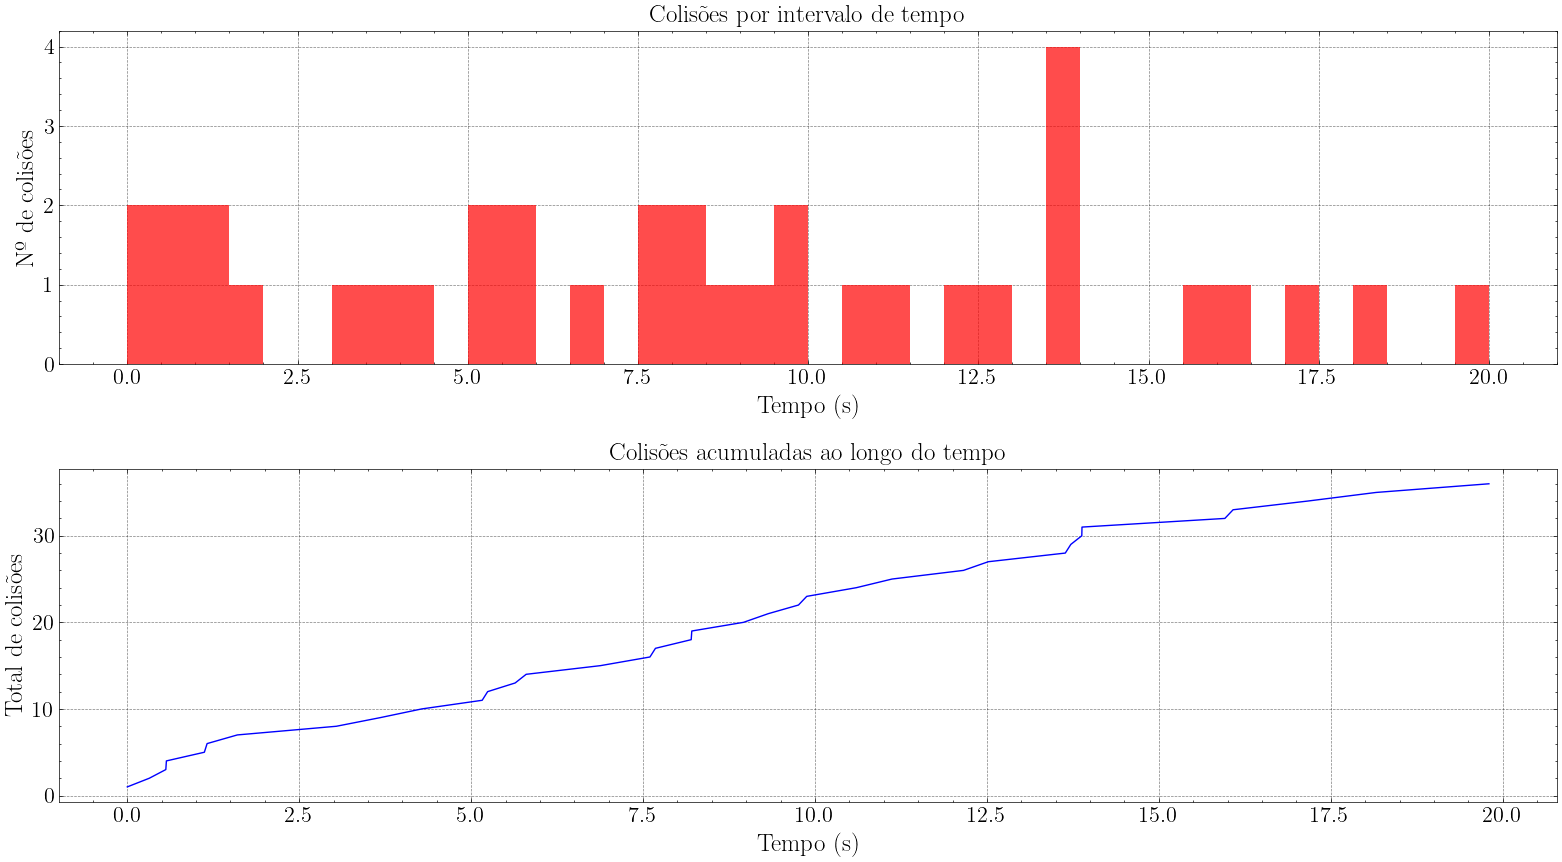

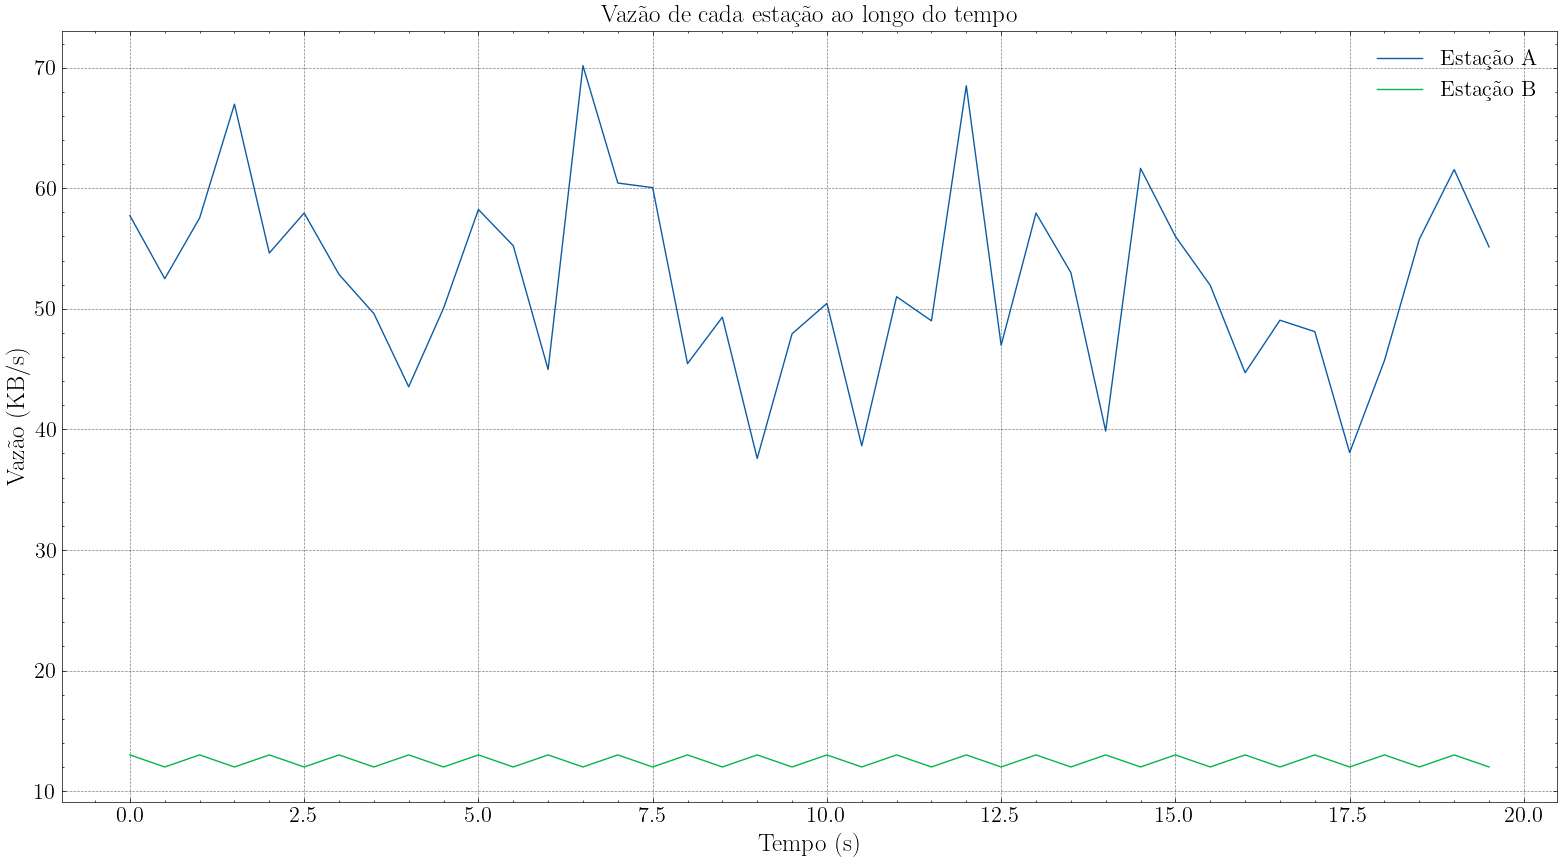

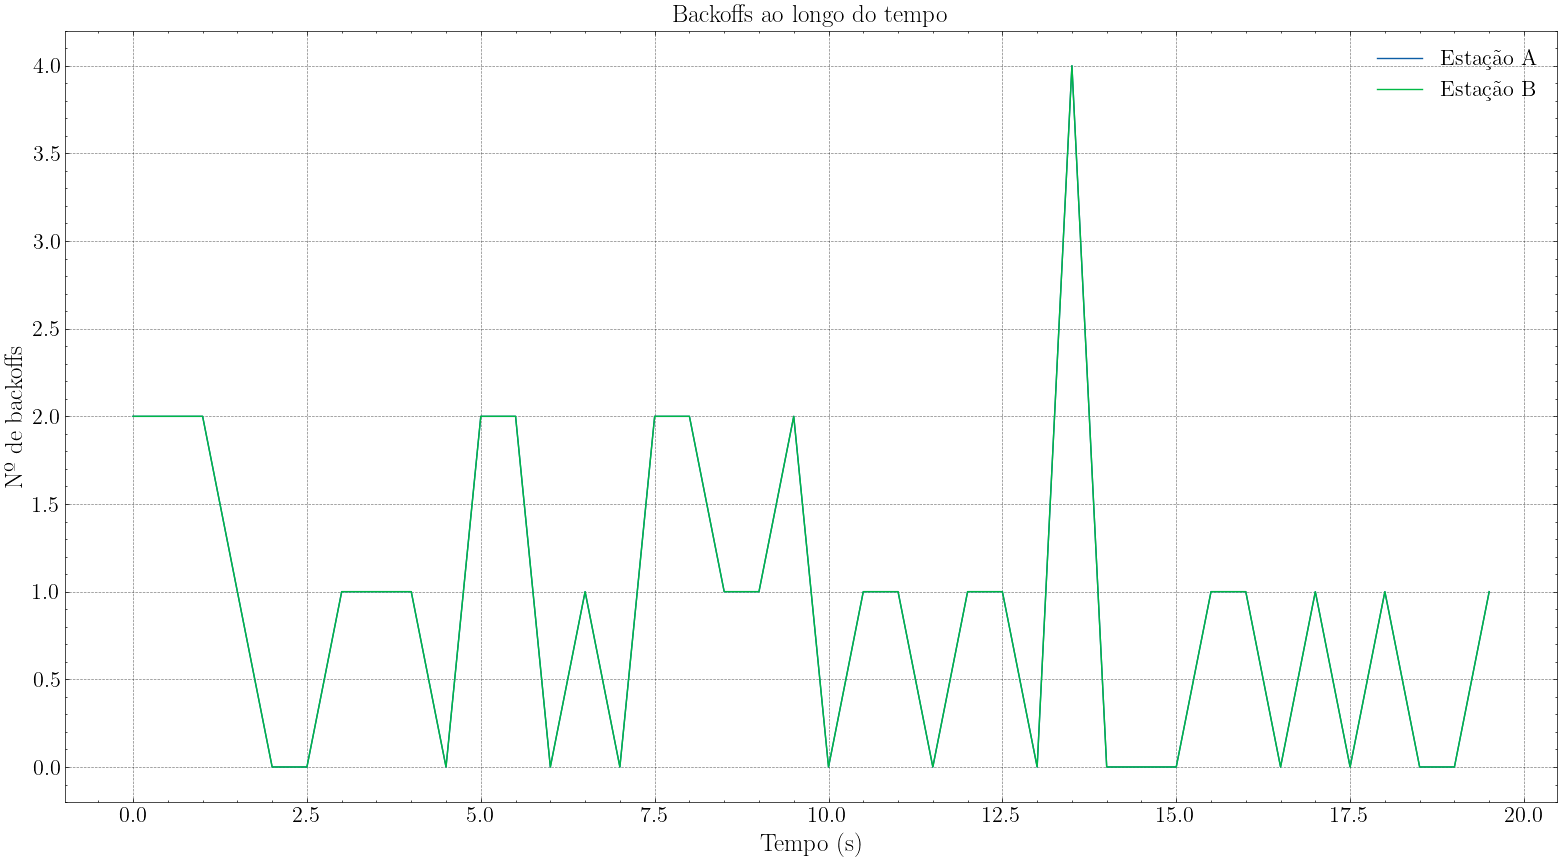

In [127]:
def main():
    sim = Simulator(SIM_TIME)
    sim.stations = {
        'A': Station('A'),
        'B': Station('B')
    }
    sim.collisions = []

    # Injeta pacote inicial na estação A
    first_pkt_size = random.randint(20, 1000)
    est_a = sim.stations['A']
    est_a.queue.append((0, first_pkt_size))
    est_a.queue_size += first_pkt_size
    sim.schedule(TransmissionStart(0, 'A'))

    # Inicia geração de pacotes
    sim.schedule(PacketArrivalA(0))
    sim.schedule(PacketArrivalB(0))
    sim.run()

    plot_results(sim)

if __name__ == "__main__":
    main()